In [2]:

# set the matplotlib backend so figures can be saved in the background
import matplotlib

# import the necessary packages
from bib.models import ResNet
from bib.az_dataset import load_mnist_dataset
from bib.az_dataset import load_az_dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the A-Z and MNIST datasets

In [3]:
print("[INFO] loading datasets...")
(azData, azLabels) = load_az_dataset('/content/drive/My Drive/a_z_handwritten_data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...
11493376/11490434 [==============================] - 0s 0us/step


## Preparing the data and the labels

In [4]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}


# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]



## Split the data into train and test 

In [5]:

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

## Data augmentation

In [6]:

# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")


## Build and train the model 

In [7]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50
INIT_LR = 1e-1
BS = 128

# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [8]:

# train the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)


[INFO] training network...
Epoch 1/50
2765/2765 [==============================] - 185s 67ms/step - loss: 1.8637 - accuracy: 0.8705 - val_loss: 0.5100 - val_accuracy: 0.9095
Epoch 2/50
2765/2765 [==============================] - 187s 68ms/step - loss: 0.9393 - accuracy: 0.9283 - val_loss: 0.4951 - val_accuracy: 0.9142
Epoch 3/50
2765/2765 [==============================] - 187s 67ms/step - loss: 0.8556 - accuracy: 0.9359 - val_loss: 0.5809 - val_accuracy: 0.8772
Epoch 4/50
2765/2765 [==============================] - 186s 67ms/step - loss: 0.8163 - accuracy: 0.9384 - val_loss: 0.5657 - val_accuracy: 0.8780
Epoch 5/50
2765/2765 [==============================] - 185s 67ms/step - loss: 0.7868 - accuracy: 0.9403 - val_loss: 0.5293 - val_accuracy: 0.8948
Epoch 6/50
2765/2765 [==============================] - 184s 67ms/step - loss: 0.7652 - accuracy: 0.9415 - val_loss: 0.5073 - val_accuracy: 0.9020
Epoch 7/50
2765/2765 [==============================] - 184s 66ms/step - loss: 0.7517 - acc

In [ ]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

#save the model to disk
print("[INFO] serializing network...")
model.save("handwriting.model", save_format="h5")

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")


## Classify characters

In [ ]:

# initialize our list of output images
images = []

# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]

	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)

	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)

	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)

	# add the image to our list of output images
	images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

In [ ]:

# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow


## Load the handwriting OCR model

In [ ]:
print("[INFO] loading handwriting OCR model...")
model = load_model('/content/handwriting.model')

## Image preprocessing 

In [19]:
import cv2
import numpy as np



# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#adaptiveThresholding
def adadaptiveThresholding(image):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#cropping
def cropping(image):
    return image[200:510,200:2200]


#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

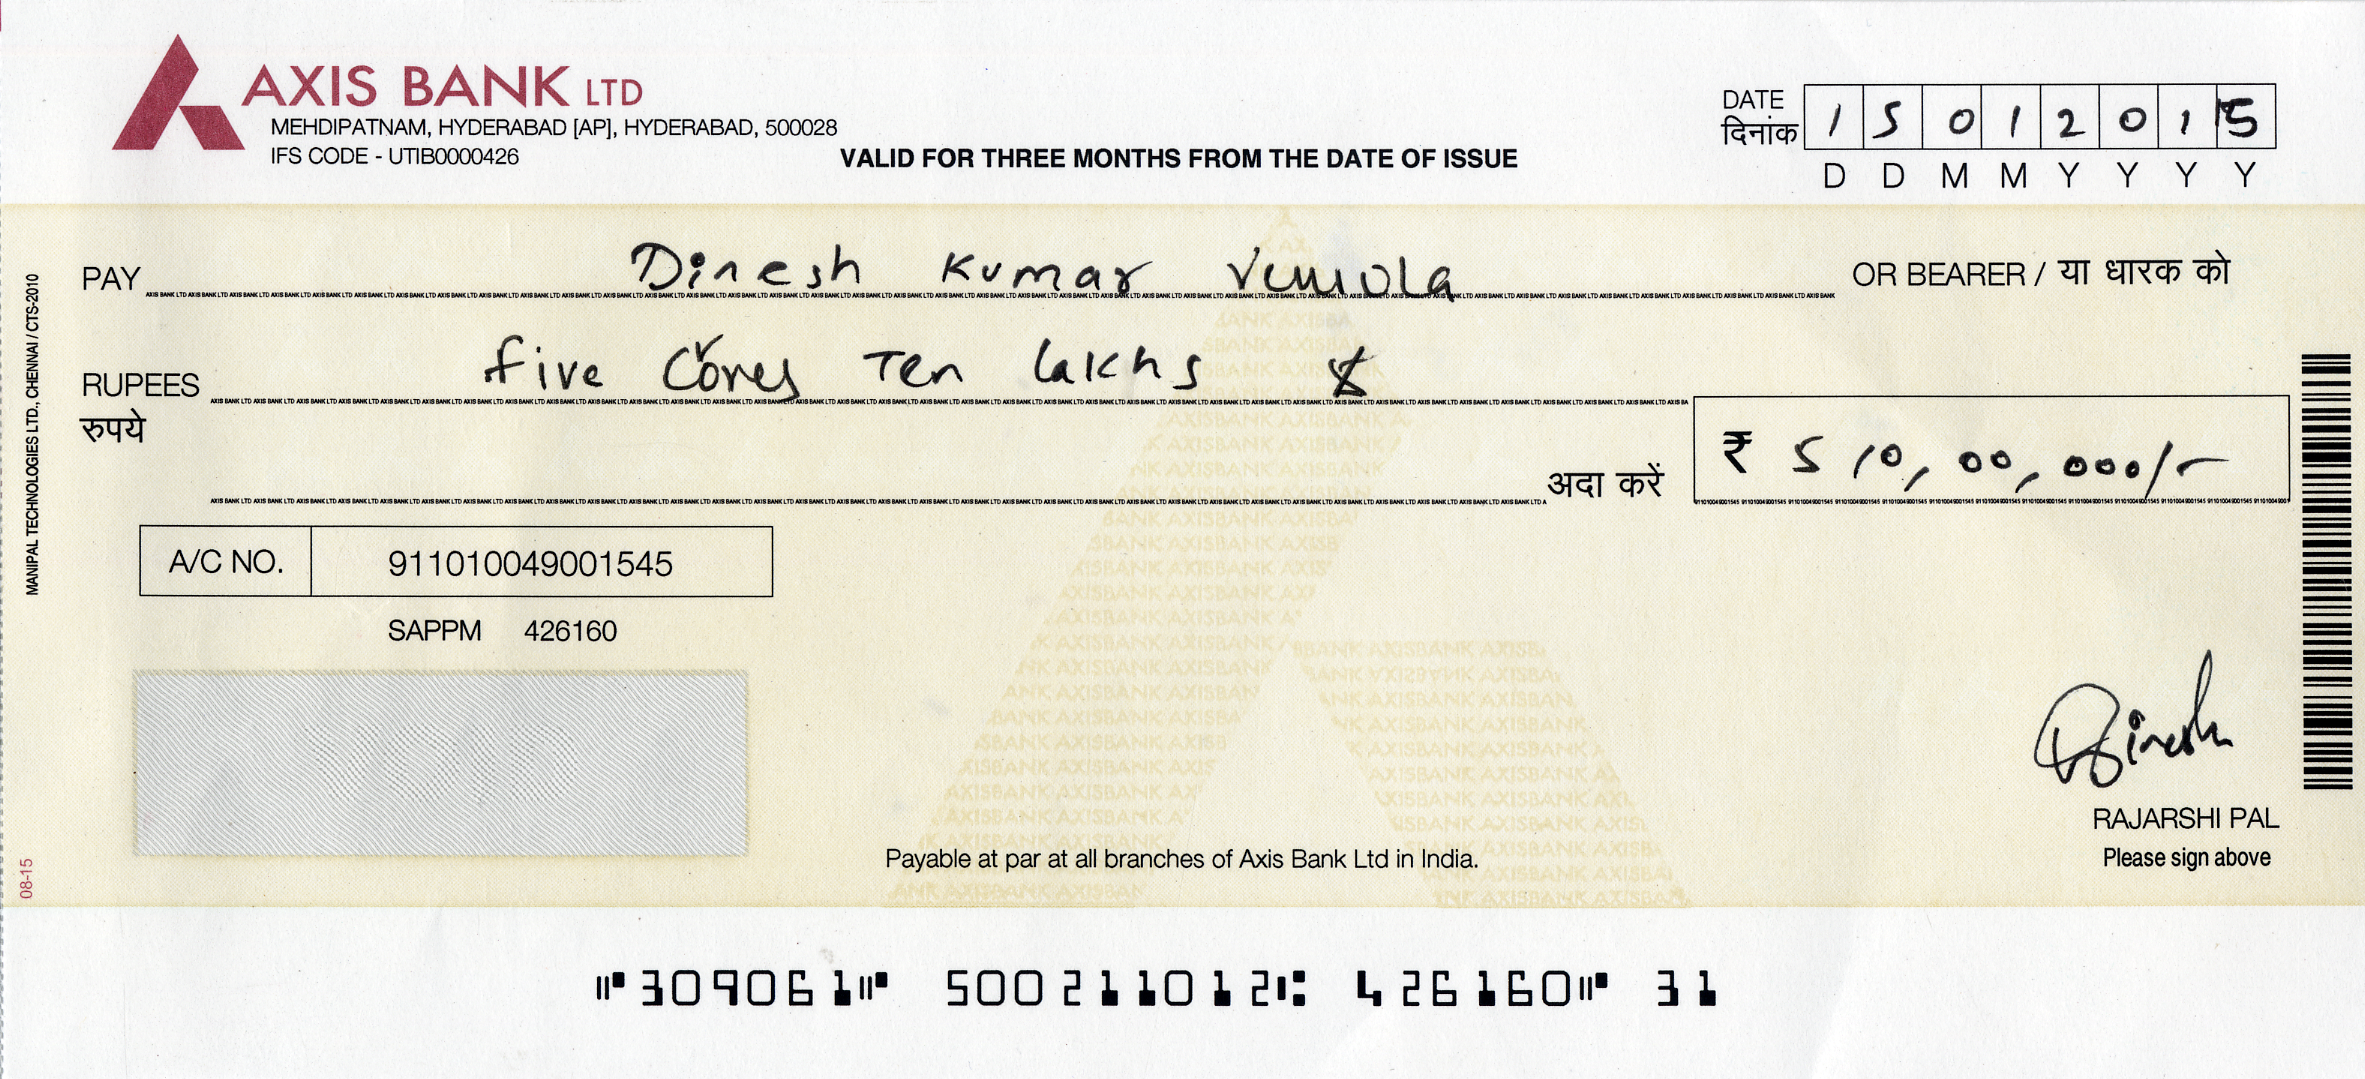

In [20]:
img = cv2.imread('/content/drive/My Drive/data/Cheque 309061.jpg')
cv2_imshow(img)

#1 -  Gray Scale

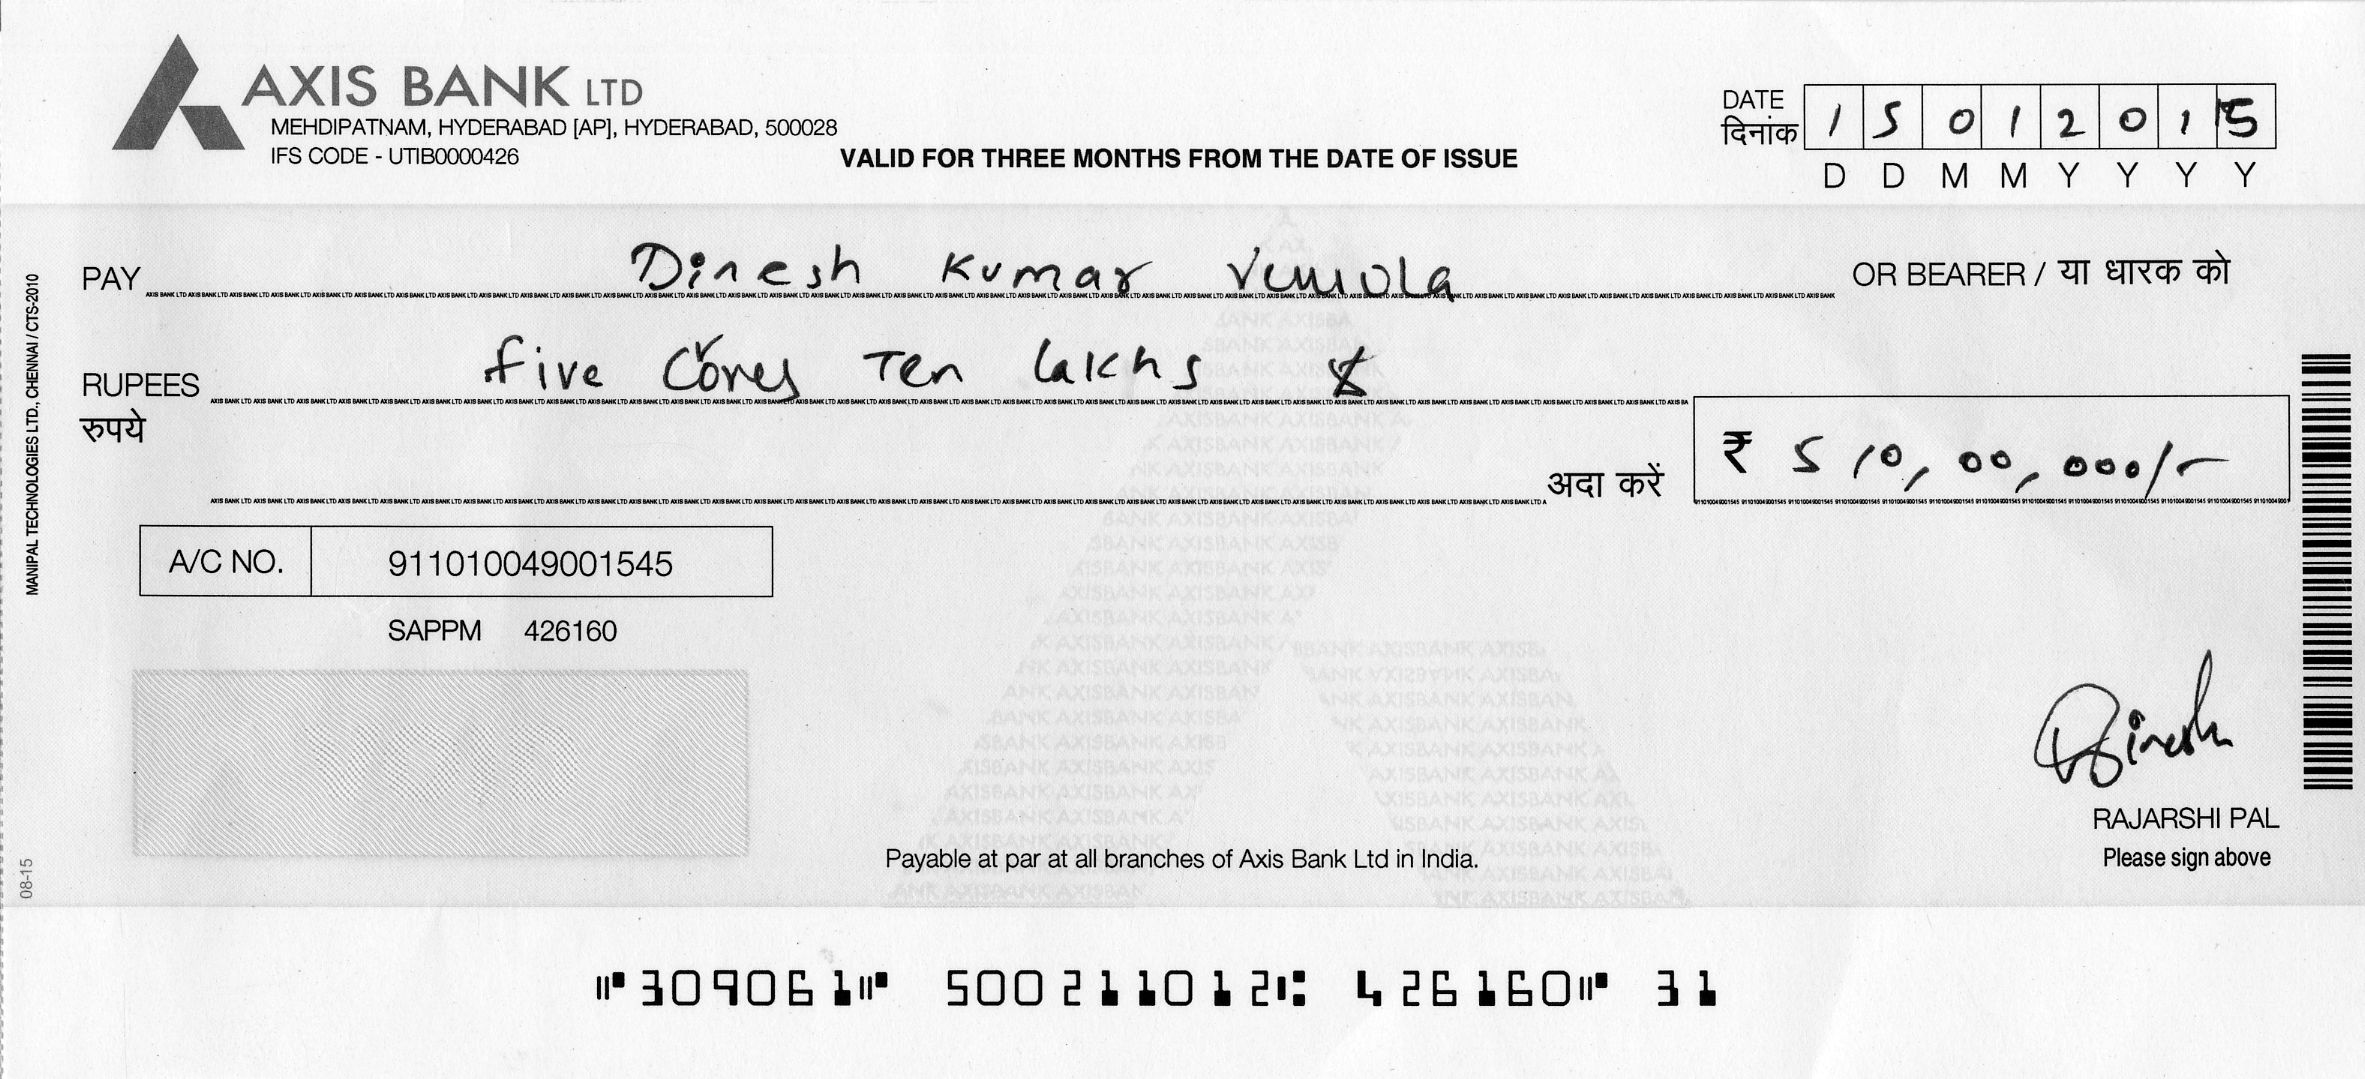

In [21]:
gray=get_grayscale(img)
cv2_imshow(gray)

# 2- Denoising

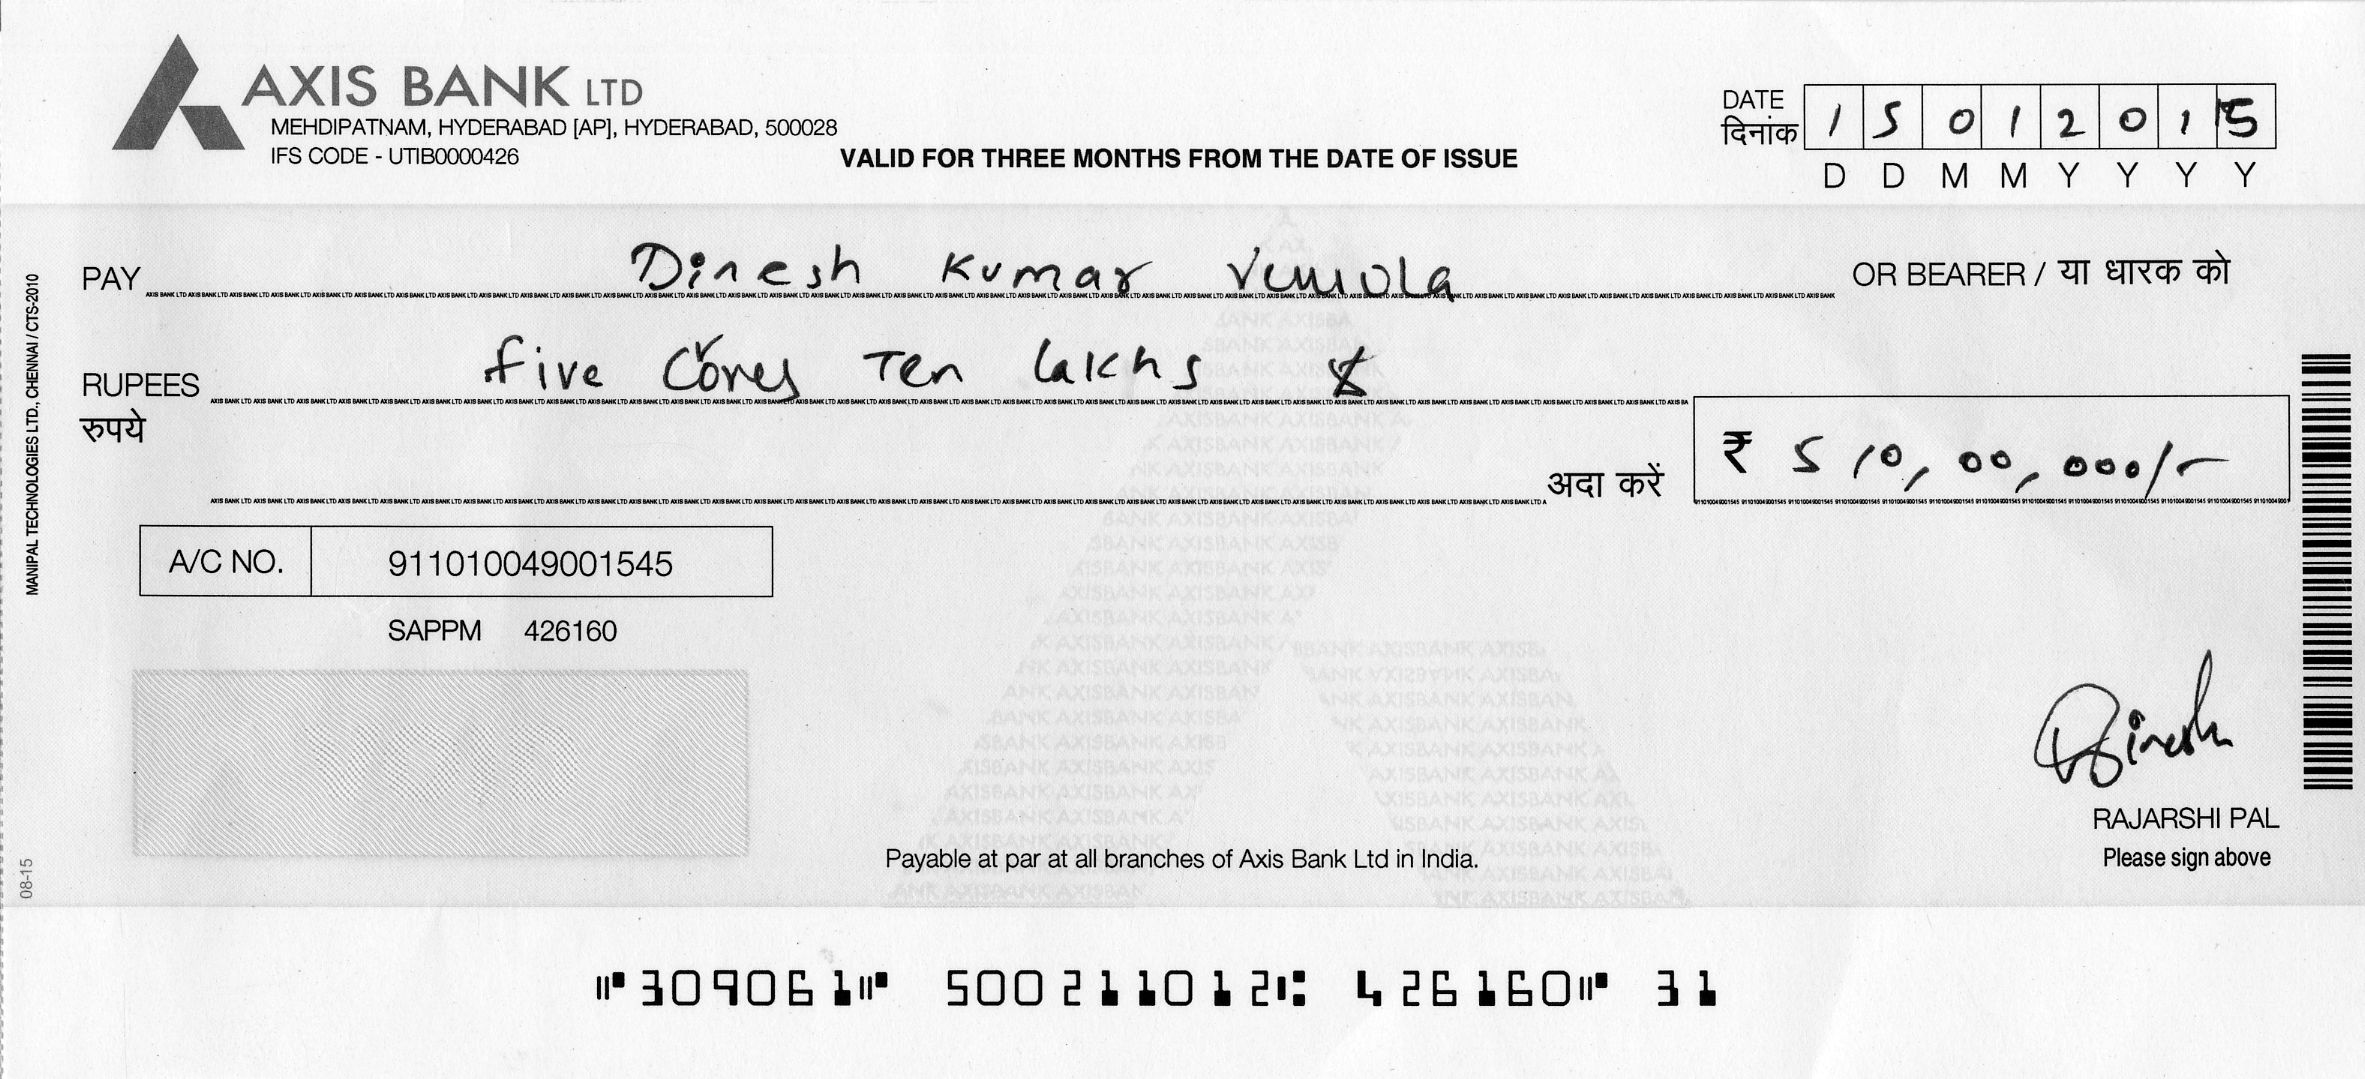

In [22]:
denoised=remove_noise(gray)
cv2_imshow(gray)

# 2- Binirasition

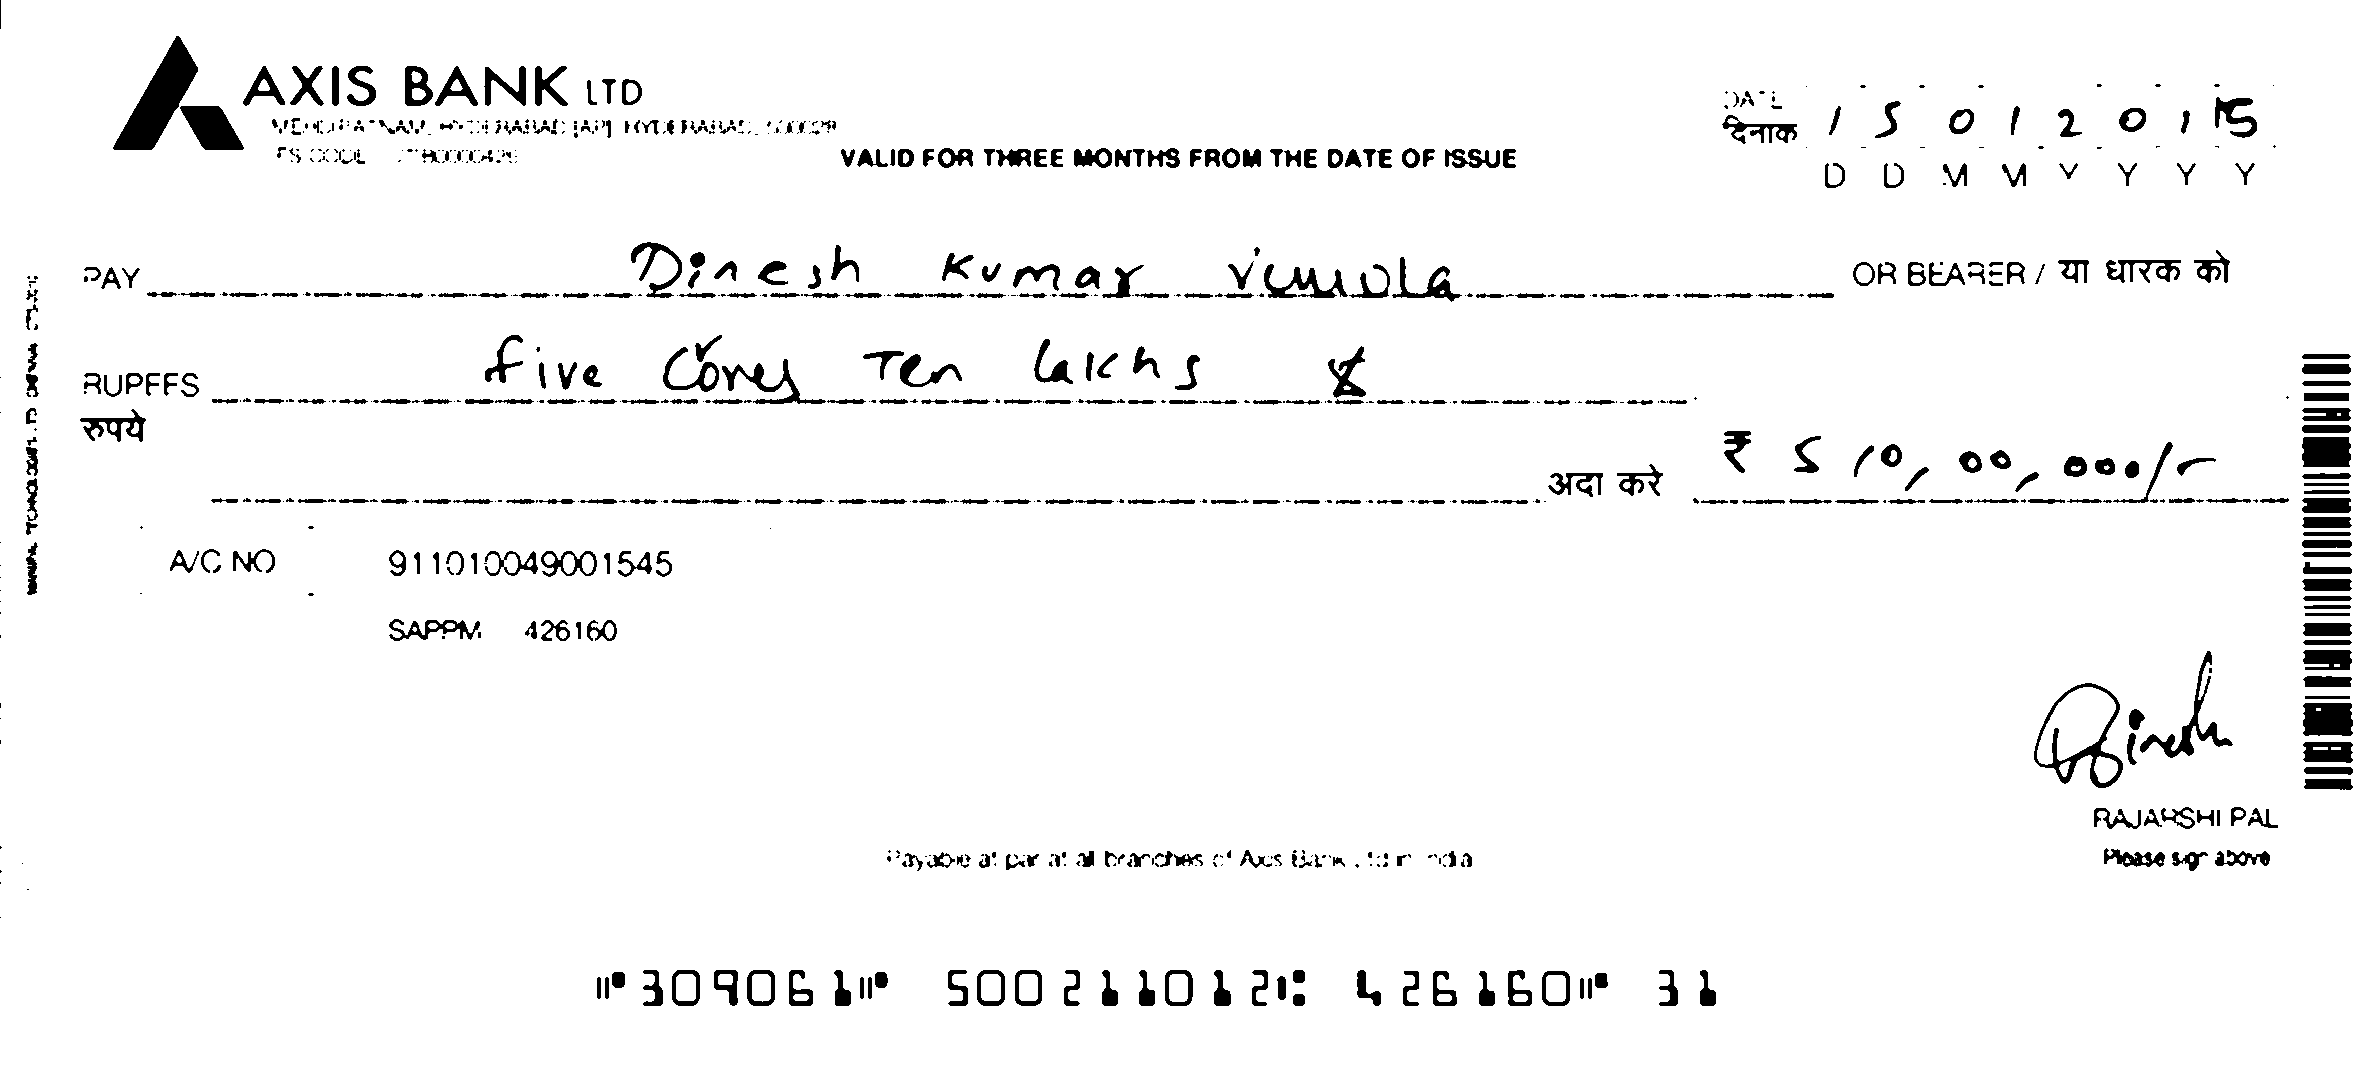

In [23]:
thresh = thresholding(denoised)
cv2_imshow(thresh)

# 3- De-Skewing

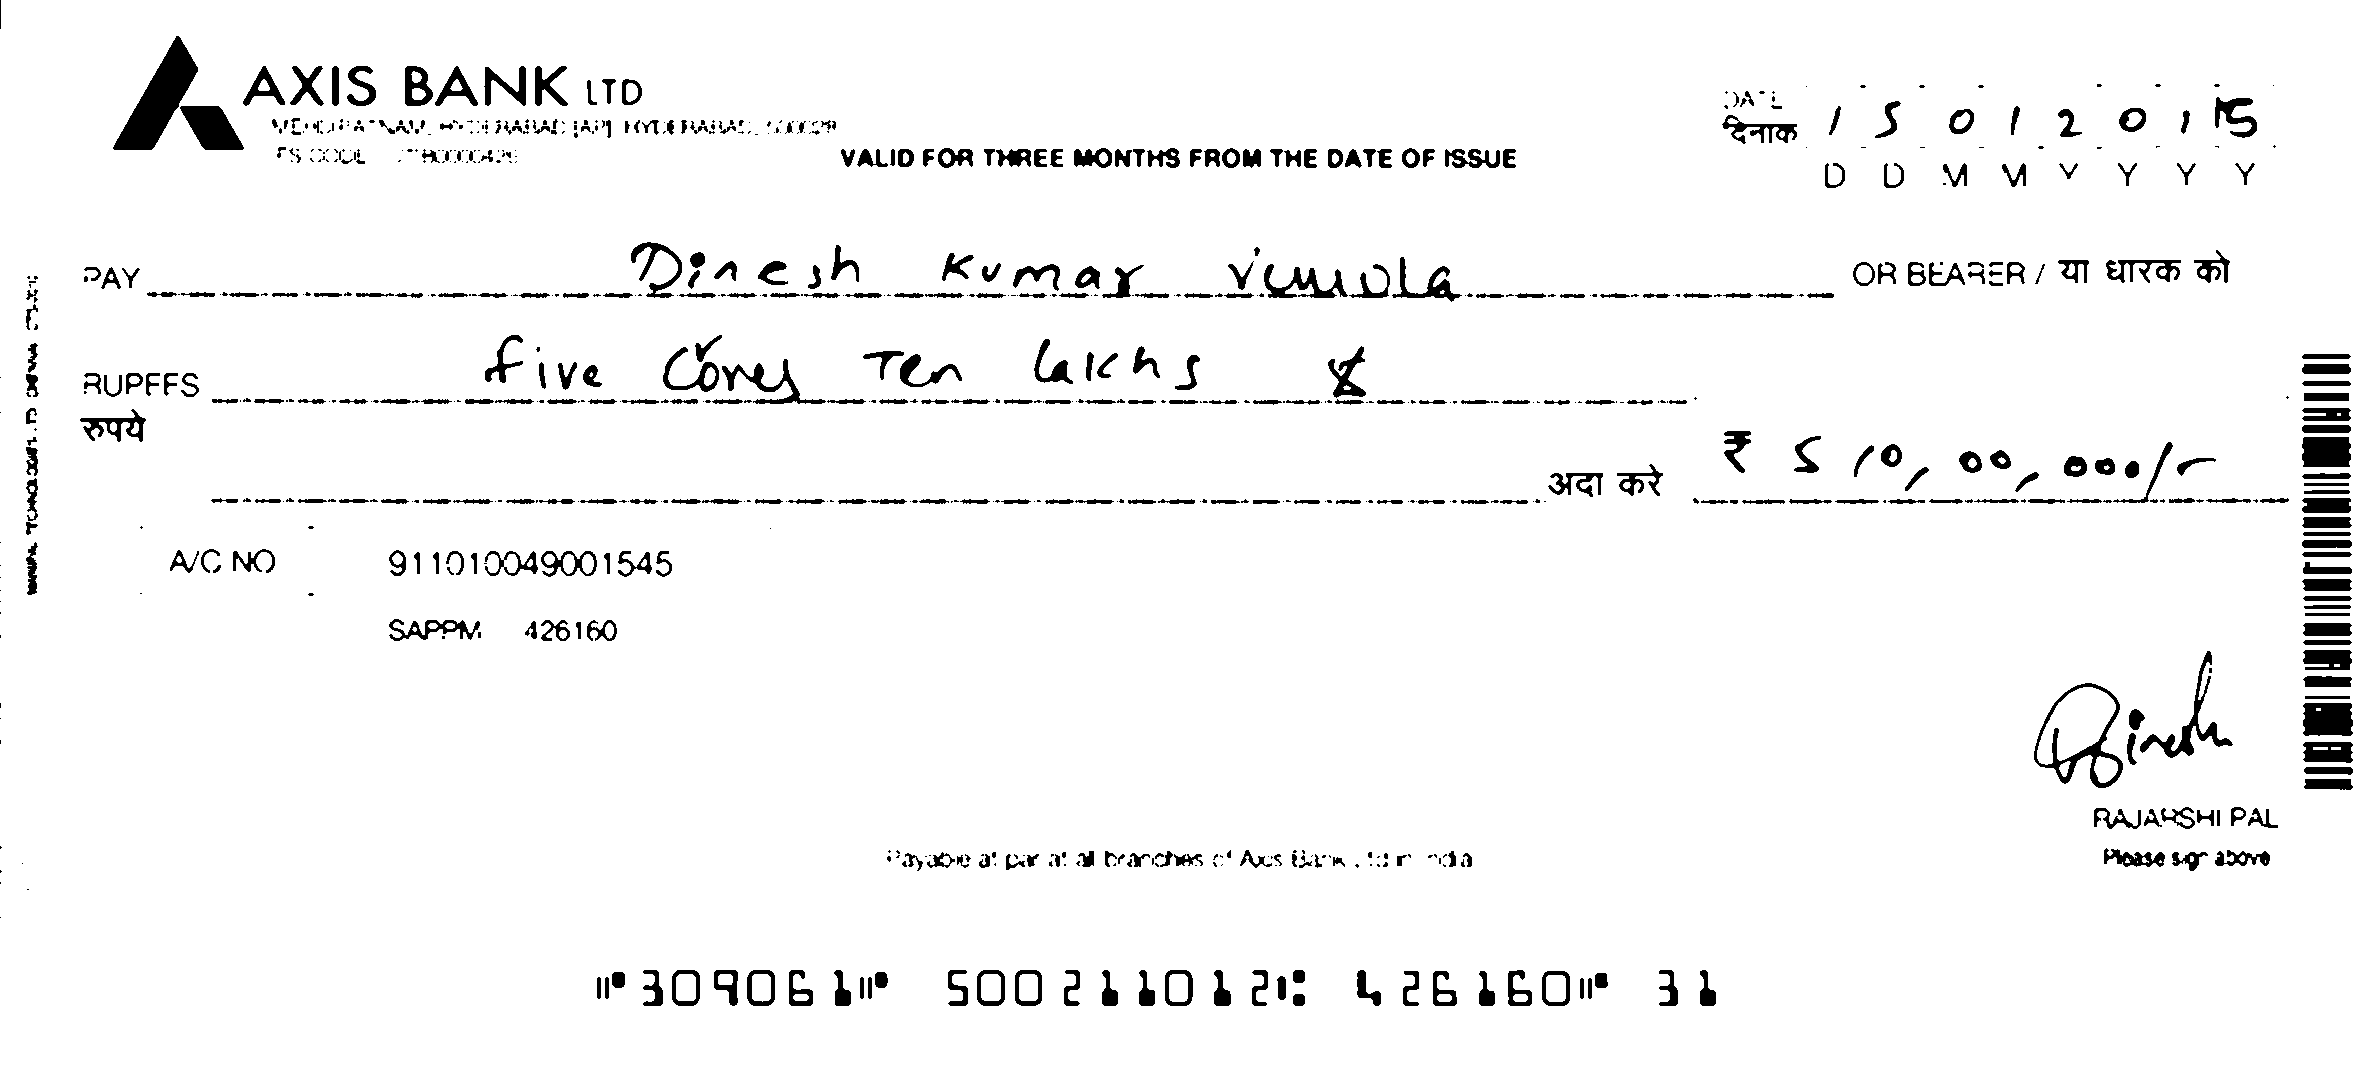

In [24]:
deskewed=deskew(thresh)
cv2_imshow(deskewed)

I choose to just keep the name and the amount of money and get rid the non important information

## 4- Cropping

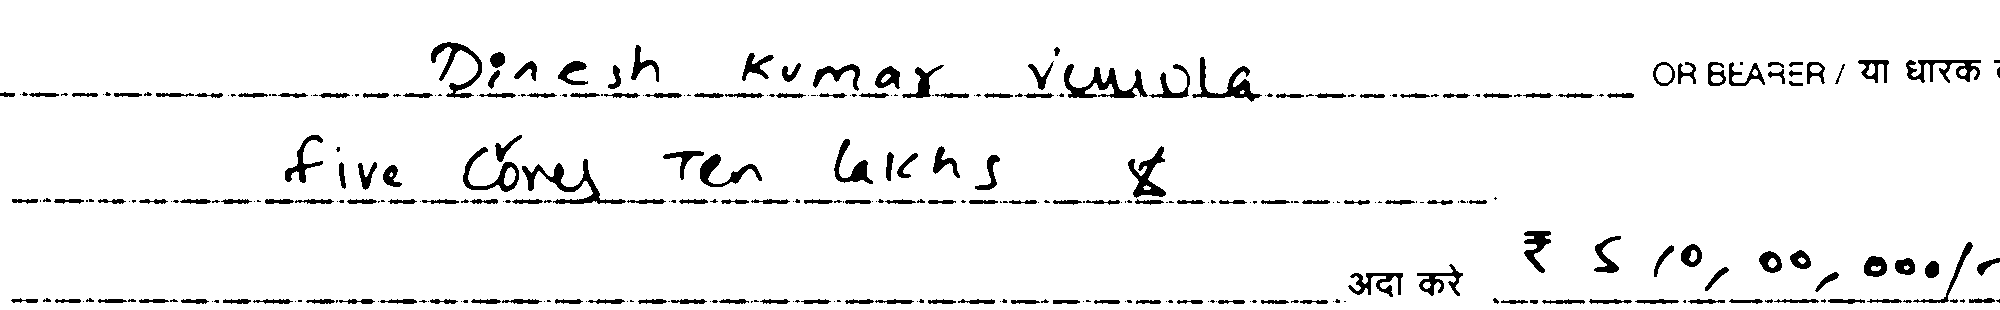

In [25]:
cropped=cropping(deskewed)
cv2_imshow(cropped)

In [ ]:

edged = cv2.Canny(cropped, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]


[INFO] loading handwriting OCR model...


In [ ]:

# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)

		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)

		# re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))


In [ ]:

# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]
	# draw the prediction on the image
	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(cropped, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(cropped, label, (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
	# show the image
	cv2_imshow(cropped)
	cv2.waitKey(0)

##EasyOCR

In [11]:
pip install easyocr

     |████████████████████████████████| 48.4MB 63kB/s 


In [12]:
from easyocr import Reader

In [13]:
def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [26]:

# OCR the input image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(['en'], gpu = True)
results = reader.readtext(cropped)

[INFO] OCR'ing input image...


[INFO] 0.1404: Dineuh
[INFO] 0.0131: zuLLa
[INFO] 0.0744: Kumax
[INFO] 0.0475: q d
[INFO] 0.0105: OP SLAIgR
[INFO] 0.2546: five
[INFO] 0.1449: ulhs
[INFO] 0.8606: Cru
[INFO] 0.4820: Te^
[INFO] 0.0391: # S
[INFO] 0.0038: 3/GT $r


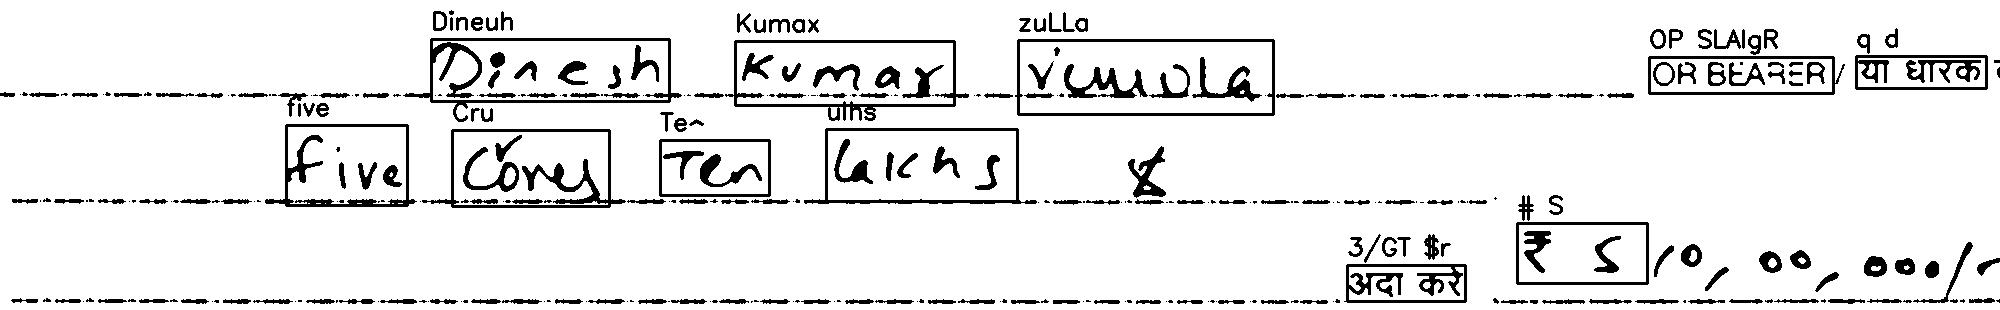

-1

In [27]:
# loop over the results
for (bbox, text, prob) in results:
	# display the OCR'd text and associated probability
	print("[INFO] {:.4f}: {}".format(prob, text))
	# unpack the bounding box
	(tl, tr, br, bl) = bbox
	tl = (int(tl[0]), int(tl[1]))
	tr = (int(tr[0]), int(tr[1]))
	br = (int(br[0]), int(br[1]))
	bl = (int(bl[0]), int(bl[1]))
	# cleanup the text and draw the box surrounding the text along
	# with the OCR'd text itself
	text = cleanup_text(text)
	cv2.rectangle(cropped, tl, br, (0, 255, 0), 2)
	cv2.putText(cropped, text, (tl[0], tl[1] - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
# show the output image
cv2_imshow(cropped)
cv2.waitKey(0)